In [60]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import uniform, norm
import seaborn as sns

# Bayesian Linear Regression Using MCMC Random Walk

The aim of this notebook is to estimate a linear regression parameter using mcmc random walk process. The result of the simulation will then be compared to parameter estimated using the frequentist approach, which is the OLS.

Set the experiment toy data

$$ y = ax+b+\epsilon $$
$\epsilon$ ~ N(0, $\sigma^{2}$)

There are 3 parameters that we want to estimate here: a, b, and $\epsilon$

In [114]:
x = np.linspace(10, 30)

# choose arbitrary number for the parameter
a = 5
b = 0
std = 5

e = np.random.normal(loc=0, scale=std, size=len(x))
y = a*x+b+e

#### Plot the toy samples

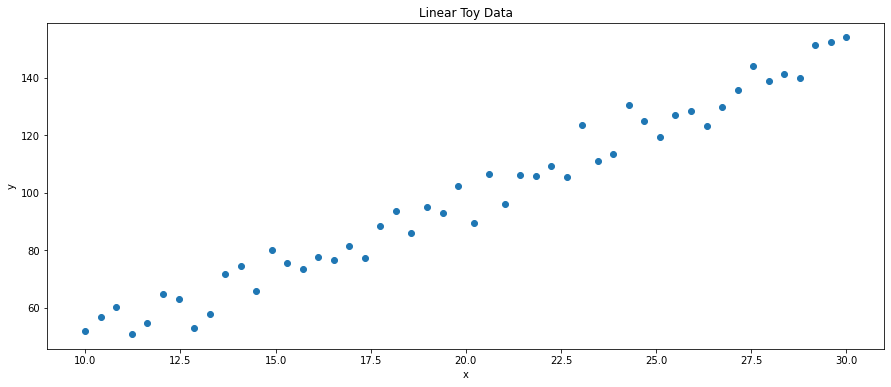

In [115]:
plt.figure(figsize=(15, 6))
plt.scatter(x, y)
plt.title('Linear Toy Data')
plt.ylabel('y')
plt.xlabel('x')
plt.show()

The first step would be to get the prior for each parameter. For simplicity, we will chose these 3 priors:
- a ~ U(0, 10)
- b ~ N(2, 4)
- std ~ U(0, 6)

Second step, set the transition probability distribution for each parameter $(q(\theta'|\theta))$. For simplicity, I choose to use normal distribution with the mean equal to previous iteration of a, b, and std, but arbitrary for the each of their standard deviation. 

Our Goal: P( a, b, std | D ), $D = (D_{1}, ..., D_{n})$, $D_{i} = (x_{i}, y_{i})$

Let $\pi$ be our target/goal distribution.

$$
\begin{align*}
\pi(a, b, std) = likelihood*prior 
=
\end{align*}
$$


### Code Setup

In [142]:
# Source: https://github.com/tirthajyoti/Stats-Maths-with-Python/blob/master/R_Functions.py

def dunif(x, minimum=0,maximum=1, log=False):
    """
    Calculates the point estimate of the uniform distribution
    """
    result = uniform.pdf(x=x,loc=minimum,scale=maximum-minimum)
    result = np.where(result==0, 1, result)
    if log:
        return np.log(result)
    else:
        return result
def dnorm(x,mean=0,sd =1, log=False):
    """
    Calculates the density of the Normal distribution
    """
    result = norm.pdf(x,loc=mean,scale=sd)
    result = np.where(result==0, 1, result)
    if log:
        return np.log(result)
    else:
        return result

In [153]:
def prior(params):
    a, b, sd = params
    aprior = dunif(a, minimum=0, maximum=10, log=True)
    bprior = dnorm(b, mean=0, sd=5, log=True)
    sdprior = dunif(sd, minimum=0, maximum=10, log=True)
    return aprior+bprior+sdprior

def likelihood(params, x):
    a, b, sd = params
    y_hat = a*x+b
    
    # the likelihood probability for each D given the parameter
    d_likelihood = dnorm(x, mean=y_hat, sd=sd, log=True)
    tot_likelihood = np.sum(d_likelihood)
    return tot_likelihood

# this is the pi
def posterior(params, x):
    return prior(params)+likelihood(params, x)

def proposal(params):
    # random std
    arr_std = np.array([0.1, 0.5, 0.3])
    return np.random.normal(loc=params, scale=arr_std, size=3)

def random_walk(starting_position, walking_steps, space):
    
    # to calculate the acceptance rate
    accept = 0
    
    # set the chain array first
    history_walk = np.zeros((walking_steps+1, 3))
    history_walk[0, :] = starting_position
    
    # iterate for every possible steps we have
    for step in range(1, walking_steps+1):
        proposed_step = proposal(history_walk[step-1, :])
        accept_proposed_step = np.exp(posterior(proposed_step, space)-posterior(history_walk[step-1, :], space))
        
        if accept_proposed_step==np.nan:
            accept_proposed_step = 0
        
        # random uniform; hence the name random walk
        random_acceptance_rate = np.random.uniform(size=1)
        
        # determine whether we should accept the proposed step or not using random uniform
        if accept_proposed_step>random_acceptance_rate:
            history_walk[step, :] = proposed_step
            accept += 1
        else:
            history_walk[step, :] = history_walk[step-1, :]
            
    return history_walk, accept/walking_steps


### Conduct Experiment

In [154]:
# set the seed first
np.random.seed(42)
initial_value = np.array([4, 0, 4])
steps = 10000
view_walk, acceptance_rate = random_walk(initial_value, steps, x)

<ipython-input-153-4335a7492d73>:38: RuntimeWarning: overflow encountered in exp
  accept_proposed_step = np.exp(posterior(proposed_step, space)-posterior(history_walk[step-1, :], space))


In [155]:
view_walk

array([[ 4.        ,  0.        ,  4.        ],
       [ 4.04967142, -0.06913215,  4.19430656],
       [ 4.2019744 ,  0.0703885 ,  4.49746115],
       ...,
       [ 0.99677411,  0.05542495,  0.05887778],
       [ 0.99677411,  0.05542495,  0.05887778],
       [ 0.99677411,  0.05542495,  0.05887778]])

In [156]:
acceptance_rate

0.0166

0.97 is a really high acceptance rate. A good acceptance rate is probably around 0.3 "Hejung Shim ~ Head lecturer in Melbourne University for Modern Applied Statistic"

### Result and Diagnostic Plot

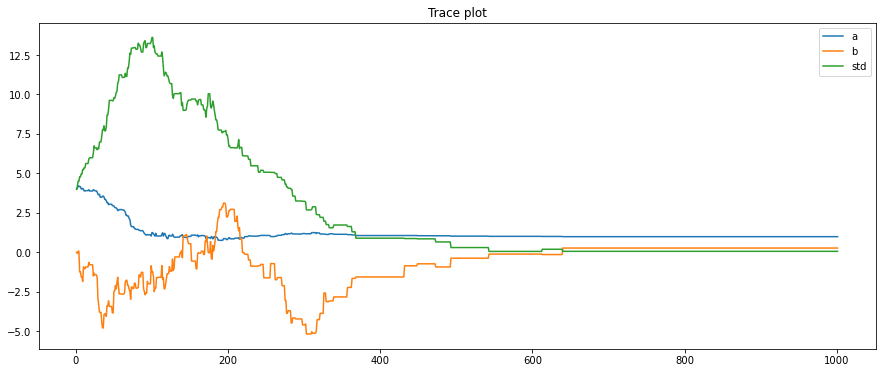

In [148]:
plt.figure(figsize=(15, 6))
plt.plot(list(range(1, steps+2)), view_walk[:,0], label='a')
plt.plot(list(range(1, steps+2)), view_walk[:,1], label='b')
plt.plot(list(range(1, steps+2)), view_walk[:,2], label='std')
plt.legend()
plt.title('Trace plot')
plt.show()

Plot each parameter result in histogram plot

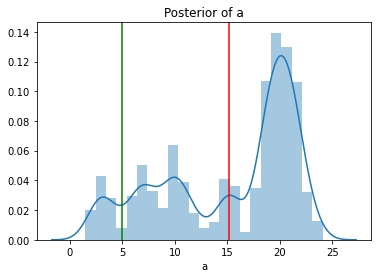

In [113]:
sns.distplot(view_walk[:, 0])
plt.title('Posterior of a')
plt.xlabel('a')
plt.axvline(x=np.mean(view_walk[:, 0]), color='r', label='estimated value')
plt.axvline(x=a, color='g', label='ground truth value')
plt.show()

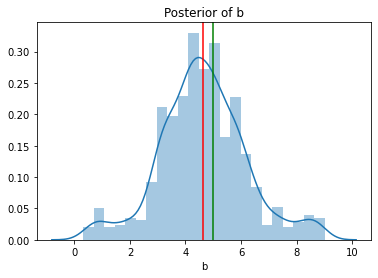

In [71]:
sns.distplot(view_walk[:, 1])
plt.title('Posterior of b')
plt.xlabel('b')
plt.axvline(x=np.mean(view_walk[:, 1]), color='r', label='estimated value')
plt.axvline(x=a, color='g', label='ground truth value')
plt.show()

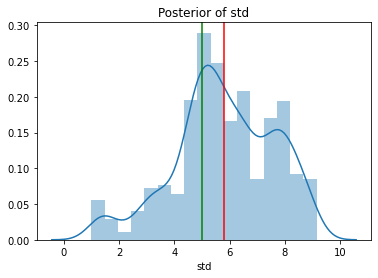

In [70]:
sns.distplot(view_walk[:, 2])
plt.title('Posterior of std')
plt.xlabel('std')
plt.axvline(x=np.mean(view_walk[:, 2]), color='r', label='estimated value')
plt.axvline(x=a, color='g', label='ground truth value')
plt.show()